# VII. Image classification with ML algorithm

---
**Author(s):** Kenji Ose, Dino Ienco, Quentin Yeche - [UMR TETIS](https://umr-tetis.fr) / [INRAE](https://www.inrae.fr/)

---

## 1. Introduction

We will present a way to classify satellite images according to a land cover typology. Here we present only a few basic principles. This is not a course on machine learning techniques or best practices.

## 2. Import libraries

As usual, we import all the required Python libraries. The new one is `sklearn` (*scikit-learn*), a package that provides simple and efficient tools for predictive data analysis.

In [1]:
import pystac_client
import planetary_computer
import rasterio as rio
import stackstac

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

import xarray as xr

from IPython.display import Image
import rich.table

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import numpy as np

## 3. Getting a Sentinel-2 image

Here are some code snippets you should be familiar with by now. We want to load a Sentinel-2 image.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

sel_item = catalog.get_collection("sentinel-2-l2a").get_item("S2B_MSIL2A_20230226T103919_R008_T31TEJ_20230228T091155")

In [3]:
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in sel_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

In [4]:
print("RGB preview of the Sentine-2 image")
Image(url=sel_item.assets["rendered_preview"].href, width=250)

RGB preview of the Sentine-2 image


## 4. Looking for training dataset

For this example, we choose a land-use/land-cover map generated by [Impact Observatory](https://www.impactobservatory.com/). A real reference, with information acquired in the field or from expert knowledge (e.g. photo-interpretation) would be preferable.

Impact Observatory data is available on Planetary Computer's STAC Catalog, so retrieving the data is very simple.


In [5]:
bbox = [3.698959,43.501749,4.015503,43.687239]

search = catalog.search(
                collections=["io-lulc-9-class"],
                bbox=bbox,
                sortby="datetime"
                )

    # convert stac catalog into item collection
items_lulc = search.item_collection()
for i in items_lulc: print(i)

<Item id=31T-2017>
<Item id=31T-2018>
<Item id=31T-2019>
<Item id=31T-2020>
<Item id=31T-2021>
<Item id=31T-2022>


We get a list of six items for our area of interest. We keep the last item corresponding to the year 2022, which is the same as our Sentinel-2 image we want to classify.

In [6]:
sel_lulc = catalog.get_collection("io-lulc-9-class").get_item("31T-2022")
Image(url=sel_lulc.assets["rendered_preview"].href, width=250)

## 5. Data pre-processing

### 5.1. Converting `item` to `xarray`

We convert the satellite image and the labeled dataset to `xarray`.

In [7]:
band_list = ['B01','B02','B03','B04','B05','B06','B07','B08','B09','B11','B12']
ds_sentinel = stackstac.stack(sel_item, 
                     assets=band_list, 
                     epsg=2154, 
                     resolution=20,
                     bounds_latlon=bbox)

ds_lulc = stackstac.stack(sel_lulc, 
                     assets=['data'],
                     epsg=2154, 
                     resolution=20,
                     bounds_latlon=bbox)
labels = list(np.unique(ds_lulc.values))
print(f"lulc unique label values: {labels}")

/home/quentin/miniconda3/envs/beyond/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/quentin/miniconda3/envs/beyond/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


lulc unique label values: [1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 11.0]


In [8]:
ds_lulc = ds_lulc.squeeze(drop=True)
ds_lulc

<xarray.DataArray 'stackstac-6a0b490ecc2cd42af44977d540cf383a' (y: 1046, x: 1290)>
dask.array<getitem, shape=(1046, 1290), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * x                (x) float64 7.564e+05 7.564e+05 ... 7.821e+05 7.821e+05
  * y                (y) float64 6.288e+06 6.288e+06 ... 6.267e+06 6.267e+06
    proj:shape       object {89288, 51219}
    start_datetime   <U20 '2022-01-01T00:00:00Z'
    proj:epsg        int64 32631
    proj:bbox        object {5320646.335981226, 756093.7865768094, 4427766.33...
    ...               ...
    end_datetime     <U20 '2023-01-01T00:00:00Z'
    io:tile_id       <U3 '31T'
    proj:transform   object {0.0, 5320646.335981226, 9.999999999999996, -10.0...
    raster:bands     object {'nodata': 0, 'spatial_resolution': 10}
    file:size        int64 193597530
    epsg             int64 2154
Attributes:
    spec:        RasterSpec(epsg=2154, bounds=(756360, 6267200, 782160, 62881...
    crs:         epsg:2154
    transform:   | 20.00, 0.00, 756360.00|\n| 0.00,-20.00, 6288120.00|\n| 0.0...
    resolution:  20

### 5.2. Displaying the land use/cover (lulc) layer

The information about the classes for Impact Observatory is available [here](https://collections.sentinel-hub.com/impact-observatory-lulc-map/readme.html):

In [9]:
legend = {1:'Water', 2:'Trees', 4:'Flooded vegetation', 
          5:'Crops', 7:'Built area', 8:'Bare ground', 11:'Rangeland'}


colors = {1: '#419bdf',
 2: '#397d49',
 4: '#7a87c6',
 5: '#e49635',
 7: '#c4281b',
 8: '#a59b8f',
 11: '#a8ebff'}

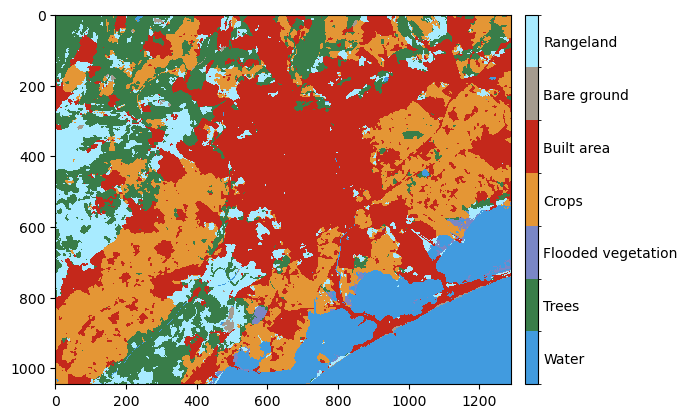

In [10]:
# color map from colors
cm = ListedColormap(colors.values())

labels = list(legend.values())
len_lab = len(labels)

# prepare normalizer
# Prepare bins for the normalizer
norm_bins = np.sort([*colors.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
# Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

fig = plt.figure()
plot = ImageGrid(fig, 111, (1, 1),
                 axes_pad=0.2,
                 cbar_mode='single',
                 cbar_location='right',
                 cbar_size='3%',
                 cbar_pad='3%')


im = plot[0].imshow(ds_lulc.squeeze(), cmap=cm, norm=norm, aspect='equal', interpolation='nearest')

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = plot.cbar_axes[0].colorbar(im, format=fmt, ticks=tickz)
cb.ax.tick_params(size=0)
plt.show()

## 6. Classification with ML methods

To classify satellite images, we need to split the reference dataset into two sub-datasets: 

- training dataset: to train the ML model, 
- test dataset: to assess the performances of the trained model.

Some lines of code presented below could be quite tricky to understand, they aim to reshape input data into the format expected by Scikit-learn functions.

### 6.1. Reshaping input data

Here, it's like playing with a rubik's cube... We move the axes of our xarray in order to make their shape conform to the specifications of the scikit-learn functions.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/10/Rubiks_cube.jpg?20051109150753" width="30%" alt="datacube nightmare">

The first thing we need to do is to remove the time dimension of size 1. As seen previously this can easily be done by calling `squeeze` which will delete the extraneous dimensions with size 1.

Then we need to move the band dimension to the position, since scikit-learn requires the bands to be in the last position (this is the standard for regular RGB(A) images).

In this notebook we will use methods which are not specific to images (for this [scikit-image](https://scikit-image.org/) is a good tool), so each pixel is treated equally regardless of its position in the image. This is why we also reshape the x and y dimension into a single dimension.

In [11]:
# loading reference date
arr_lulc = ds_lulc.to_numpy()
y_data = arr_lulc

# loading and reshaping of satellite date
print("Reshaping of satellite data array\n------")
arr_sentinel = ds_sentinel.to_numpy()
print(f"shape step 0: {arr_sentinel.shape}")
arr_sentinel = arr_sentinel.squeeze()
print(f"shape step 1: {arr_sentinel.shape}")
x = np.moveaxis(arr_sentinel, 0, -1)
print(f"shape step 2: {x.shape}")
# using -1 makes it so numpy calculates the required size of the dimension
# based on the other specified dimension sizes. So here the size will be
# 1046*1290 = 1349340
X_data = x.reshape(-1, 11)
print(f"shape step 3: {X_data.shape}")


Reshaping of satellite data array
------


shape step 0: (1, 11, 1046, 1290)
shape step 1: (11, 1046, 1290)
shape step 2: (1046, 1290, 11)
shape step 3: (1349340, 11)


### 6.2. Data normalization

scikit-learn provides several ready-to-use methods to perform data normalization. Here, we choose the `StandardScaler` method to standardize features by removing the mean and scaling to unit variance.

In [12]:
# Satellite date normalization
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)

### 6.3. Training and test datasets

We're using the `train_test_split` function to split our data into two training and test datasets. We can specify the size of the test dataset as a fraction of the total dataset. We also use the `stratify` parameter which will ensure that the different classes of land cover from y_data are balanced in both datasets.

In [13]:
# Split data
print("Splitting input data into training/test datasets\n-----")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), 
                                                    test_size=0.70, stratify = y_data.ravel())
print(f"X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}")

Splitting input data into training/test datasets
-----


X_train Shape: (404802, 11)
X_test Shape: (944538, 11)
y_train Shape: (404802,)
y_test Shape:(944538,)


### 6.4. Training a Random Forest model

Once training and test data are ready, we can train the ML model with the `fit` function of *Scikit-learn*. Here we choose the **Random Forest** algorithm. 

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

### 6.5. Inference

Here, we apply with the `predict` function of *Scikit-learn* the trained model on the satellite image in order to predict landcover type for all pixels.


In [15]:
# Predict the labels of test data
rf_pred = rf.predict(X_test)

### 6.6. Assessment

Now, we assess the prediction against test dataset. Here, the scores are not very good. It should be interesting to improve the model by changing the training sample strategy, by testing other model's parameters.

In [16]:
print(f"Accuracy: {accuracy_score(y_test, rf_pred)*100}")
print(classification_report(y_test, rf_pred))


Accuracy: 78.84214293125316
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98    136673
         2.0       0.74      0.82      0.78    150837
         4.0       0.58      0.38      0.46      5064
         5.0       0.70      0.80      0.75    226443
         7.0       0.85      0.84      0.85    328630
         8.0       0.77      0.38      0.51      2563
        11.0       0.51      0.29      0.37     94328

    accuracy                           0.79    944538
   macro avg       0.73      0.64      0.67    944538
weighted avg       0.78      0.79      0.78    944538



## 7. Plotting results

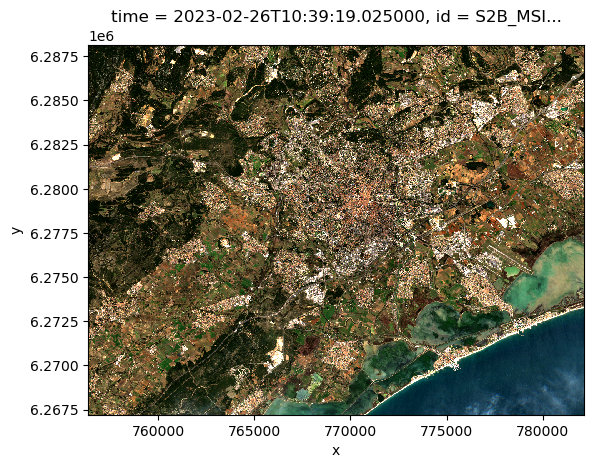

In [17]:
ds_sentinel.squeeze().sel(band=['B04', 'B03', 'B02']).plot.imshow(robust=True)

In [18]:
ds_sentinel = ds_sentinel.compute()
ds_lulc = ds_lulc.compute()

In [19]:
output = rf.predict(X_scaled).reshape((1046, 1290))

In [21]:
ds_rgb = ds_sentinel.squeeze().sel(band=['B04', 'B03', 'B02']).transpose('y', 'x', 'band')
quantile = ds_rgb.quantile(.95, dim=['y', 'x'])
ds_rgb_clipped = xr.where(ds_rgb<quantile, ds_rgb, quantile)
mini, maxi = ds_rgb_clipped.min(dim=('y','x')), ds_rgb_clipped.max(dim=('y','x'))
ds_rgb_normed = (ds_rgb_clipped - mini)/(maxi - mini)

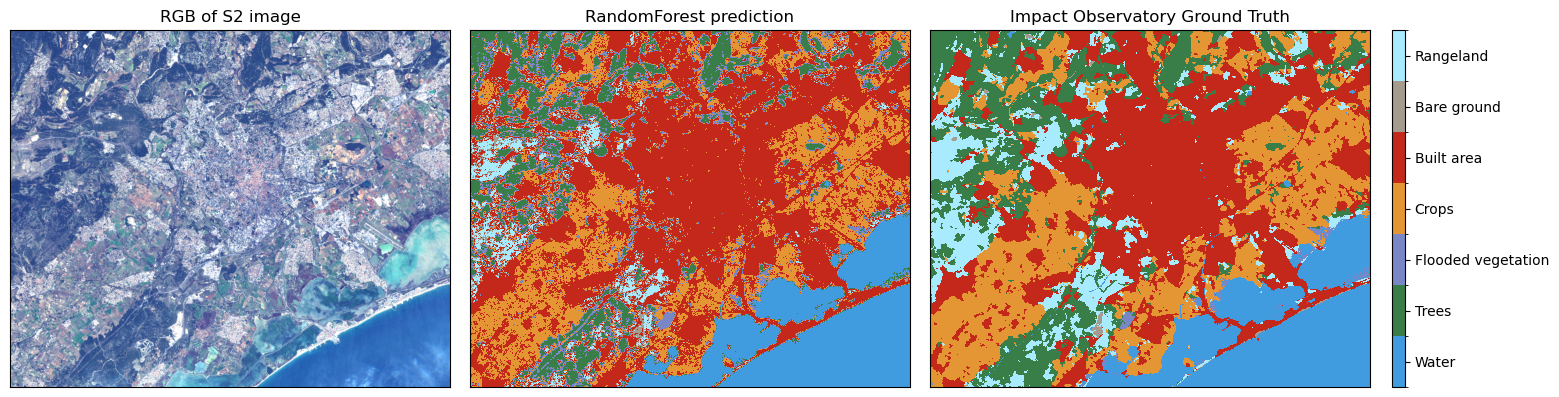

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(18,10))
plot = ImageGrid(fig, 111, (1, 3),
                 axes_pad=0.2,
                 cbar_mode='single',
                 cbar_location='right',
                 cbar_size='3%',
                 cbar_pad='5%')

plot[0].imshow(ds_rgb_normed.values)
plot[0].set_title('RGB of S2 image')

plot[1].imshow(output, cmap=cm, norm=norm)
plot[1].set_title('RandomForest prediction')

im = plot[2].imshow(ds_lulc, cmap=cm, norm=norm, interpolation='nearest')
plot[2].set_title('Impact Observatory Ground Truth')

for ax in plot:
    ax.set_yticks([])
    ax.set_xticks([])

plot.cbar_axes[0].colorbar(im, format=fmt, ticks=tickz)
fig.show()